## Business Problem
<p>Instacart, a grocery order and the delivery app with over 500 Million products and 40000 stores serves across U.S. & Canada. Instacart provides a user experience where you will get product recommendation based on your previous orders.</p>
<p>Instacart provided us with transactional data of customer orders over time to predict which previously purchased products will be in a user’s next order. This data is open-sourced and given as a Kaggle challenge.</p>

## Real-World / Business Objectives and Constraints
<p>The objective is to predict which products will be in a user’s next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, Instacart provided between 4 and 100 of their orders, along with the sequence in which products were placed in the cart.</p>

## Ml formulation of business problem
<p>For the user to get product recommendations based on his past N orders, we need to observe patterns and generate rules which will give recommendations with high probability. Since we have over 3 Million data points, we need to automate this learning process and using Machine Learning we can achieve this to give probabilistic prediction. Machine Learning works better on large sets of data and generates rules from patterns learned from features.</p>
<p>Other Alternative would be a rule based system, which works best when we know the rules. But it’s very difficult to generate rules by going over all data samples manually and make sense of the patterns. This can’t guarantee in high predictive power</p>

## Which Metric to use
<p> from the problem statement perspective we need to recommend a product to the user and cost of not recommending a product(which is gonne be bought) is less.</p>
<p>As there are 4 metrics that can be used Accuracy, LogLoss, Roc_AUC Curve, F1 Score</p>
<p><b>why not Accuracy -</b></p> 
	<ul>
	<li>Doesn't care about probablitites</li>
	<li>it gives equal importance to negative class but from our problem the positive class is more important</li>
	</ul>
	
	
	
<p><b>why not LogLoss - </b></p>
	<ul>
	<li>it gives equal importance to negative class but from our problem the positive class is more important</li>
	</ul>
	

<p><b>why not ROC_AUC curve -</b></p>
	<p>if a model is performing bad for true positive class(imbalnced data, Positive has less data points) then it is still gonne give a decent score to that model.
	example - </p>
		<p>model (1) predicts 5 positives out of 100 true positives in a dataset of size 10K observations, while another model (2) predicts 90 positives out of 100 true positives.</p>
		<p>F1 score for model (1) = 2*(1)*(0.1)/1.1 = 0.095</p>
		<p>F1 score for model (2) = 2*(1)*(0.9)/1.9 = 0.947</p>
		
		<p>ROC-AUC for model (1) = 0.5</p>
		<p>ROC-AUC for model (2) = 0.93</p>
		
<p><b>why F1 score -</b></p> 
	<ul>
	<li>Good with imbalnced data</li>
	<li>Can do the tuninf of the threhold</li>
	<li>Care more about the True positive class, which we want in our problem statement</li>
	</ul>
	

## Feature Engineering

In [2]:
import pandas as pd
import numpy as np
import os
import json
import xgboost as xgb
from tqdm import tqdm
import sklearn.metrics

In [3]:
#Load Data
path = "Data"
aisles = pd.read_csv(os.path.join(path, "aisles.csv"), dtype={'aisle_id': np.uint8, 'aisle':'category'})
departments = pd.read_csv(os.path.join(path, "departments.csv"), dtype={'department_id':np.uint8, 'department': 'category'})
order_prior = pd.read_csv(os.path.join(path, "order_products__prior.csv"), dtype={'order_id': np.uint32,
                                                                                  'product_id': np.uint16,
                                                                                  'add_to_cart_order':np.uint8,
                                                                                  'reordered': bool})
order_train = pd.read_csv(os.path.join(path, "order_products__train.csv"), dtype={'order_id': np.uint32,
                                                                                  'product_id': np.uint16,
                                                                                  'add_to_cart_order':np.uint8,
                                                                                  'reordered': bool})
orders = pd.read_csv(os.path.join(path, "orders.csv"), dtype={'order_id':np.uint32,
                                                              'user_id': np.uint32,
                                                              'eval_set': 'category',
                                                              'order_number':np.uint8,
                                                              'order_dow': np.uint8,
                                                              'order_hour_of_day': np.uint8
                                                              })
products = pd.read_csv(os.path.join(path, "products.csv"), dtype={'product_id': np.uint16,
                                                                  'aisle_id': np.uint8,
                                                                  'department_id': np.uint8})
print('loaded')

loaded


In [13]:
# order_id and Product_id with no duplicates, we take only orders from prior that are in train data
# so we create a train model dataframe, we are gonne merge all the feature into this, and rows number would gonne be same after inserting all the features

order_train1 = order_train.copy()
order_train1.drop(['add_to_cart_order'], axis=1, inplace=True)
labels1 = orders[orders['eval_set']=="prior"].merge(order_prior,on='order_id')[['user_id','product_id']].drop_duplicates()
order_label = labels1.merge(orders[(orders.eval_set=="train") | (orders.eval_set=="test")], on="user_id")[['order_id','product_id','eval_set']]
labels = order_label.merge(order_train1, how='left',on=['order_id','product_id'])
labels.reordered.fillna(False, inplace=True)
labels.head()

,order_id,product_id,eval_set,reordered
0,1187899,196,train,True
1,1187899,14084,train,False
2,1187899,12427,train,False
3,1187899,26088,train,True
4,1187899,26405,train,True


In [16]:
# features on user_id, Product_id and days_since_prior_order

merged = orders.merge(order_prior,on='order_id').sort_values(['user_id','order_number'])
cumulative_sum_days_since_prior_order = merged.copy()
merged_cum_sum = cumulative_sum_days_since_prihe or_order.groupby('order_id')[['user_id','days_since_prior_order','order_number']].agg(max).sort_values(['user_id','order_number'])
temp = merged_cum_sum.groupby(['user_id']).agg({'days_since_prior_order':'cumsum'}).rename(columns={'days_since_prior_order':"days_since_prior_order_cum_sum"})
merged_with_cum_sum = merged_cum_sum.merge(temp,on='order_id')
merged_with_cum_sum_prod = merged_with_cum_sum.merge(merged[['order_id','product_id']],on='order_id')
list_days = merged_with_cum_sum_prod.groupby(['user_id','product_id'])['days_since_prior_order_cum_sum'].progress_apply(list)
list_days = list_days.to_frame(name='cum_sum days_before_product_ordered' )

list_days['days_before_product_ordered-1'] = list_days.groupby(['user_id','product_id']).progress_apply(lambda x: np.subtract(list(x['cum_sum days_before_product_ordered'].values)[0][-1],list(x['cum_sum days_before_product_ordered'].values)[0][-2]) if len(list(x['cum_sum days_before_product_ordered'].values)[0]) > 1 and list(x['cum_sum days_before_product_ordered'].values)[0][-2]>1 else list(x['cum_sum days_before_product_ordered'].values)[0][-1] if len(list(x['cum_sum days_before_product_ordered'].values)[0]) > 1 and np.isnan(list(x['cum_sum days_before_product_ordered'].values)[0][-2]) else np.NAN)
list_days['days_before_product_ordered-2'] = list_days.groupby(['user_id','product_id']).progress_apply(lambda x: np.subtract(list(x['cum_sum days_before_product_ordered'].values)[0][-2],list(x['cum_sum days_before_product_ordered'].values)[0][-3]) if len(list(x['cum_sum days_before_product_ordered'].values)[0]) > 2 and list(x['cum_sum days_before_product_ordered'].values)[0][-3]>2 else list(x['cum_sum days_before_product_ordered'].values)[0][-2] if len(list(x['cum_sum days_before_product_ordered'].values)[0]) > 2 and np.isnan(list(x['cum_sum days_before_product_ordered'].values)[0][-3]) else np.NAN)
list_days['days_before_product_ordered-3'] = list_days.groupby(['user_id','product_id']).progress_apply(lambda x: np.subtract(list(x['cum_sum days_before_product_ordered'].values)[0][-3],list(x['cum_sum days_before_product_ordered'].values)[0][-4]) if len(list(x['cum_sum days_before_product_ordered'].values)[0]) > 3 and list(x['cum_sum days_before_product_ordered'].values)[0][-4]>3 else list(x['cum_sum days_before_product_ordered'].values)[0][-3] if len(list(x['cum_sum days_before_product_ordered'].values)[0]) > 3 and np.isnan(list(x['cum_sum days_before_product_ordered'].values)[0][-4]) else np.NAN)
list_days['days_before_product_ordered-4'] = list_days.groupby(['user_id','product_id']).progress_apply(lambda x: np.subtract(list(x['cum_sum days_before_product_ordered'].values)[0][-4],list(x['cum_sum days_before_product_ordered'].values)[0][-5]) if len(list(x['cum_sum days_before_product_ordered'].values)[0]) > 4 and list(x['cum_sum days_before_product_ordered'].values)[0][-5]>4 else list(x['cum_sum days_before_product_ordered'].values)[0][-4] if len(list(x['cum_sum days_before_product_ordered'].values)[0]) > 4 and np.isnan(list(x['cum_sum days_before_product_ordered'].values)[0][-5]) else np.NAN)
list_days['days_before_product_ordered_mean'] = list_days.groupby(['user_id','product_id']).progress_apply(lambda x: np.nanmean(list(x['cum_sum days_before_product_ordered'].values)[0]))
list_days['days_before_product_ordered_median'] = list_days.groupby(['user_id','product_id']).progress_apply(lambda x: np.nanmedian(list(x['cum_sum days_before_product_ordered'].values)[0]))
list_days.to_csv('list_days_final.csv')

list_days = pd.read_csv('list_days_final.csv',usecols=['user_id','product_id','days_before_product_ordered-1','days_before_product_ordered-2','days_before_product_ordered-3','days_before_product_ordered-4','days_before_product_ordered_mean','days_before_product_ordered_median'])
list_days.head()

,user_id,product_id,days_before_product_ordered-1,days_before_product_ordered-4,days_before_product_ordered-2,days_before_product_ordered_mean,days_before_product_ordered-3,days_before_product_ordered_median
0,1,196,30.0,20.0,0.0,102.333333,14.0,112.0
1,1,10258,30.0,20.0,0.0,102.333333,14.0,112.0
2,1,10326,NaN,NaN,NaN,93.000000,NaN,93.0
3,1,12427,30.0,20.0,0.0,102.333333,14.0,112.0
4,1,13032,44.0,NaN,117.0,107.666667,NaN,132.0


In [68]:
# features on user_id and Departments

orders_prior = orders.merge(order_prior,on='order_id')[['order_id', 'user_id', 'product_id','reordered']]
orders_prior_department_reordered = orders_prior.merge(products,on='product_id').drop_duplicates()[['user_id','order_id','product_id','department_id','reordered']]
orders_prior_department_reordered = orders_prior_department_reordered.groupby(['user_id','department_id']).agg({'product_id':'nunique','reordered':'sum'})
orders_prior_department_reordered = orders_prior_department_reordered.rename(columns={'product_id':'unique_prod_in_department','reordered':'department_product_reordered'})
orders_prior_department_reordered.to_csv('orders_prior_department_reordered.csv')

orders_prior_department_reordered = pd.read_csv('orders_prior_department_reordered.csv')
orders_prior_department_reordered.head()

,user_id,department_id,unique_prod_in_department,department_product_reordered
0,1,4,4,1
1,1,7,2,11
2,1,13,1,0
3,1,14,1,2
4,1,16,5,8


In [64]:
# features on user_id and aisle

orders_prior = orders.merge(order_prior,on='order_id')[['order_id', 'user_id', 'product_id','reordered']]
orders_prior_aisle_reordered = orders_prior.merge(products,on='product_id').drop_duplicates()[['user_id','order_id','product_id','aisle_id','reordered']]
orders_prior_aisle_reordered = orders_prior_aisle_reordered.groupby(['user_id','aisle_id']).agg({'product_id':'nunique','reordered':'sum'})
orders_prior_aisle_reordered = orders_prior_aisle_reordered.rename(columns={'product_id':'unique_prod_in_aisle','reordered':'aisle_product_reordered'})
orders_prior_aisle_reordered.to_csv('orders_prior_aisle_reordered.csv')

orders_prior_aisle_reordered = pd.read_csv('orders_prior_aisle_reordered.csv')
orders_prior_aisle_reordered.head()

,user_id,aisle_id,unique_prod_in_aisle,aisle_product_reordered
0,1,21,1,7
1,1,23,2,10
2,1,24,4,1
3,1,45,1,0
4,1,53,1,1


In [21]:
# Features on Product_id, add_to_cart_order, reordered

productFeat = order_prior.groupby('product_id').agg({'add_to_cart_order':'mean', 'reordered':['sum','size']})
productFeat['Reorder_product_prob'] = productFeat['reordered']['sum']/productFeat['reordered']['size']
productFeat['addToCartNumber_NumberOfOrder'] = productFeat['add_to_cart_order']['mean']/productFeat['reordered']['size']
productFeat['add_to_cart_order_mean'] = productFeat['add_to_cart_order']['mean']
productFeat = productFeat.drop(['add_to_cart_order','reordered'],axis=1)
productFeat.columns = ['Reorder_product_prob','addToCartNumber_NumberOfOrder', 'add_to_cart_order_mean']
productFeat.head()

,Reorder_product_prob,addToCartNumber_NumberOfOrder,add_to_cart_order_mean
,,,
product_id,,,
1,0.613391,0.003133,5.801836
2,0.133333,0.109877,9.888889
3,0.732852,0.023159,6.415162
4,0.446809,0.028898,9.507599
5,0.600000,0.431111,6.466667


In [24]:
# features on user_id, orders, products and days_since_prior_order

# features on user_id, orders and days_since_prior_order
user_order_merged = orders.merge(order_prior,on='order_id')[['order_id','user_id','days_since_prior_order']]
here = user_order_merged.groupby(['order_id']).agg('max')
here1 = here.groupby('user_id').agg({'user_id':'count','days_since_prior_order':['sum','mean','median']})
here1.columns = here1.columns.levels[1]
here1 = here1.rename(columns={'count':'user_orders_count','sum':'user_median_days_since_prior_order','mean':'user_since','median':'user_mean_days_since_prior_order'})

# User Product Features
user_product_merged = orders.merge(order_prior,on='order_id')
user_product = user_product_merged.groupby('user_id').agg({'product_id':['nunique','size'],'reordered':['sum','count']})
user_product.columns = user_product.columns.levels[1]
user_product['user_reorder_ratio'] = user_product['size']/user_product['sum']
user_product = user_product.drop(['size','sum'],axis=1).rename(columns={'count':'unique_prod','nunique':'NumberTimeProductsOrdered'})

# merge both the DataFrames
user_feat1 = here1.merge(user_product,on='user_id')
user_feat1['Avergae_Basket_size'] = user_feat1['NumberTimeProductsOrdered']/user_feat1['user_orders_count']
user_feat1.head()

,user_orders_count,user_since,user_mean_days_since_prior_order,user_median_days_since_prior_order,unique_prod,NumberTimeProductsOrdered,user_reorder_ratio,Avergae_Basket_size
user_id,,,,,,,,
1,10,176.0,19.555556,20.0,18,59,0.694915,5.900000
2,14,198.0,15.230769,13.0,102,195,0.476923,13.928571
3,12,133.0,12.090909,11.0,33,88,0.625000,7.333333
4,5,55.0,13.750000,17.0,17,18,0.055556,3.600000
5,4,40.0,13.333333,11.0,23,37,0.378378,9.250000


In [25]:
# Features on product_id and users

user_order_merged = orders.merge(order_prior,on='order_id')
number_of_unique_users_for_product = user_order_merged.groupby('product_id').agg({'user_id':'nunique'})
number_of_unique_users_for_product_reordered = user_order_merged.groupby(['product_id','user_id']).agg({'reordered':'max'})
number_of_unique_users_for_product_reordered = number_of_unique_users_for_product_reordered.groupby('product_id').agg({'reordered':'sum'})
product_features1 = number_of_unique_users_for_product.rename(columns={'user_id':'number_of_unique_users_for_product'}).copy()
product_features1['number_of_unique_users_for_product_reordered'] = number_of_unique_users_for_product_reordered['reordered'].values
product_features1.head()

,number_of_unique_users_for_product,number_of_unique_users_for_product_reordered
product_id,,
1,716,276
2,78,8
3,74,36
4,182,64
5,6,4


In [27]:
# features on user_id, product_id, order_dow and orders

order_prior_merged = order_prior.merge(orders,on="order_id")
here1 = order_prior_merged.groupby(['user_id','product_id','order_dow']).agg({'reordered':['sum','size']})
here1.columns = here1.columns.levels[1]
here1 = here1.rename(columns={'sum':'week_product_reordered','size':'week_product_ordered',})
here1['week_product_reordered_ration'] = here1['week_product_reordered']/here1['week_product_ordered']
here1 = here1.fillna(value=0.0)
here1.head()

week_product_reordered  week_product_ordered  \
user_id product_id order_dow                                                 
1       196        1                               3                     3   
                   2                               1                     2   
                   3                               2                     2   
                   4                               3                     3   
        10258      1                               3                     3   

                              week_product_reordered_ration  
user_id product_id order_dow                                 
1       196        1                                    1.0  
                   2                                    0.5  
                   3                                    1.0  
                   4                                    1.0  
        10258      1                                    1.0

In [47]:
# Features on user_id, product_id and Order_id
# prod_ordersBYtotal_orders - number of products ordered in those orders the divide by number of orders done by user 
# product_ordered_last - difference of order number from last order with that product and total orders by the user
# product_ordered_first - difference of order number from first order with that product and total orders by the user

order_prior_merged = order_prior.merge(orders,on="order_id")
user_product_order_temp = order_prior_merged.groupby(['user_id', 'product_id']).agg({'user_id':'size','order_number':['min','max']})
user_product_order_temp.columns = user_product_order_temp.columns.droplevel(0)
user_product_order['prod_ordersBYtotal_orders'] = user_product_order_temp['size']/user_feat1['user_orders_count']
user_product_order['product_ordered_last'] = user_feat1['user_orders_count'] - user_product_order_temp['max']
user_product_order['product_ordered_first'] = user_feat1['user_orders_count'] - user_product_order_temp['min']
user_product_order.head()

prod_orders  prod_ordersBYtotal_orders  \
user_id product_id                                           
1       196                  10                        1.0   
        10258                 9                        0.9   
        10326                 1                        0.1   
        12427                10                        1.0   
        13032                 3                        0.3   

                    product_ordered_last  product_ordered_first  
user_id product_id                                               
1       196                            0                      9  
        10258                          0                      8  
        10326                          5                      5  
        12427                          0                      9  
        13032                          0                      8

In [54]:
# feature on order_id, product_id and add_to_cart_order
order_prior_merged = order_prior.merge(orders,on="order_id")
temp1 = order_prior_merged.groupby('order_id').agg({'add_to_cart_order':'max'}).rename(columns={'add_to_cart_order':'basket_size'})
temp1 = temp1.merge(order_prior_merged, on='order_id')
temp1['add_to_cart_order_inverse'] = temp1['basket_size']-temp1['add_to_cart_order']
temp1['add_to_cart_order_relative'] = temp1['add_to_cart_order']/temp1['basket_size']
temp1.head()

# get mean, min, max and size features
temp_data = temp1.groupby(['user_id', 'product_id']).agg({
                                                       'order_number': ['min', 'max'],
                                                       'add_to_cart_order': 'mean',
                                                       'days_since_prior_order': 'mean',
                                                       'order_dow':'mean',
                                                       'order_hour_of_day': 'mean',
                                                       'add_to_cart_order_inverse': 'mean',
                                                       'add_to_cart_order_relative': 'mean',
                                                       'reordered':'sum'})

temp_data.columns = temp_data.columns.droplevel(0)
temp_data.columns = ['prod_min_orderNumber', 'prod_max_orderNumber', 'prod_cart_mean',
                         'days_since_prior_order_mean', 'order_dow_mean','order_hour_of_day_mean',
                'add_to_cart_order_inverse_mean','add_to_cart_order_relative_mean','reordered_sum']
temp_data.head()

prod_min_orderNumber  prod_max_orderNumber  \
user_id product_id                                               
1       196                            1                    10   
        10258                          2                    10   
        10326                          5                     5   
        12427                          1                    10   
        13032                          2                    10   

                    prod_cart_mean  days_since_prior_order_mean  \
user_id product_id                                                
1       196               1.400000                    19.555556   
        10258             3.333333                    19.555556   
        10326             5.000000                    28.000000   
        12427             3.300000                    19.555556   
        13032             6.333333                    21.666667   

                    order_dow_mean  order_hour_of_day_mean  \
user_id product_id                                           
1       196               2.500000               10.300000   
        10258             2.555556               10.555556   
        10326             4.000000               15.000000   
        12427             2.500000               10.300000   
        13032             2.666667                8.000000   

                    add_to_cart_order_inverse_mean  \
user_id product_id                                   
1       196                               4.500000   
        10258                             2.666667   
        10326                             3.000000   
        12427                             2.600000   
        13032                             0.333333   

                    add_to_cart_order_relative_mean  reordered_sum  
user_id product_id                                                  
1       196                                0.245278              9  
        10258                              0.562037              8  
        10326                              0.625000              0  
        12427                              0.541667              9  
        13032                              0.962963              2

In [55]:
# product embedding uploaded by one of the competitor on kaggle 
# https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/37697
# the product embedding is created from orders Data 

product_embeddings = pd.read_pickle('data/product_embeddings.pkl')
embedings = list(range(32))
product_embeddings = product_embeddings[embedings + ['product_id']]
product_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,product_id
0,0.238604,1.467404,1.161555,0.257020,0.262400,-0.472287,-0.498063,0.617533,0.143423,0.331204,...,-0.225085,1.292168,0.023675,2.212941,0.192866,-0.677150,0.220644,-0.549214,0.328943,1
1,0.604643,0.315079,-0.612005,-0.698891,-0.060198,-0.258082,0.527160,-0.782410,0.104015,-0.357846,...,0.001443,0.597167,-0.401836,-0.673824,0.121742,0.988963,-0.378714,0.429604,-0.675098,2
2,-0.055381,-0.702918,-0.301937,-0.741934,0.294994,-0.908531,-0.095207,-0.549281,-0.978078,0.651974,...,0.021210,-0.214384,-0.812447,-0.221399,0.424221,0.276618,0.594096,-0.665587,-0.555554,3
3,-0.226095,0.666498,0.096109,0.504644,0.005883,-0.390370,-0.867693,0.195124,0.540179,0.581654,...,0.593099,0.570194,-0.138637,-0.736523,-0.268775,0.512141,-0.835119,-0.139976,0.540997,4
4,-0.327244,0.582291,-0.109301,-0.122129,-0.402943,-0.896186,0.042546,-0.195300,-0.409419,-0.314801,...,-0.171655,0.409905,0.905563,-0.796210,0.206565,0.470135,-0.127850,-0.213620,0.665445,5


In [1]:
# merging the dataframes
data = labels[labels['eval_set']=="train"]
data = data.merge(orders,on="order_id")
data = data.merge(products,on="product_id")

data = data.merge(orders_prior_aisle_reordered,on=['user_id', 'aisle_id'])
data = data.merge(orders_prior_department_reordered,on=['user_id', 'department_id'])

data = data.merge(product_features1,on='product_id')
data = data.merge(product_embeddings,on='product_id')

user_prod = list_days.merge(user_product_order,on=['user_id','product_id'])
user_prod = user_prod.merge(temp_data,on=['user_id','product_id'])
data = data.merge(user_prod,on=['user_id','product_id'])
data = data.merge(here1,on=['user_id','product_id','order_dow'], how='left')
data_train = data.merge(user_feat1,on='user_id')
data_train.to_csv('my_final/data.csv')

In [8]:
# Reading all the features
data_train = pd.read_csv('my_final/data.csv')
labels_train = data_train['reordered']

# filling NaN values as -1
data_train = data_train.fillna(-1)

## Splitting Data

In [5]:
# Splitting the data User_id wise
from sklearn.model_selection import GroupShuffleSplit

train_inds, test_inds = next(GroupShuffleSplit(test_size=.3, n_splits=1, random_state = 42).split(data_train, groups=data_train['user_id']))

data_train = data_train.drop(['Unnamed: 0', 'order_id','eval_set_x','eval_set_y','reordered','product_name','user_id','product_id','order_number','order_dow','order_hour_of_day','days_since_prior_order','aisle_id','department_id'],axis=1)

X_train1 = data_train.iloc[train_inds]
y_train1 = labels_train.iloc[train_inds]
X_cv1 = data_train.iloc[test_inds]
y_cv1 = labels_train.iloc[train_inds]

In [ ]:
from sklearn.svm import SVC
svc_clf = SVC(class_weight='balanced').fit(X_train1, y_train1)
pred_Xcv = svc_clf.predict(X_cv)
print("Confusion Matrix : ", confusion_matrix(y_cv, pred_Xcv))
df_cm = pd.DataFrame(confusion_matrix(y_cv, pred_Xcv), ['Pred_0','Pred_1'], ['Actual_0','Actual_1'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size

plt.show()
print("F1 score : ", f1_score(y_cv, pred_Xcv))

## Autoencoder

In [6]:
# https://machinelearningmastery.com/autoencoder-for-classification/
# Autoencoder for classification with compression in the bottleneck layer
# In this example I have not tried to normalize the data.
# Autoencoder without Normalization

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

X_train, X_test, y_train, y_test = X_train1, X_cv1, y_train1, y_cv1
# scale data
n_inputs = X_train.shape[1]

visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*0.75)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs*0.65)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs*0.65)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*0.75)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_withoutNorm_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
model.summary()
plot_model(model, 'autoencoder_withoutNorm.png', show_shapes=True)
history = model.fit(X_train, X_train, epochs=10, batch_size=64, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'autoencoder_withoutNorm_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('autoencoder_withoutNorm.h5')


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 68)]              0         
_________________________________________________________________
dense (Dense)                (None, 51)                3519      
_________________________________________________________________
batch_normalization (BatchNo (None, 51)                204       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 51)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                2288      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44)                176       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 44)               

<Figure size 640x480 with 1 Axes>

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 68)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 51)                3519      
_________________________________________________________________
batch_normalization_4 (Batch (None, 51)                204       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 51)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 44)                2288      
_________________________________________________________________
batch_normalization_5 (Batch (None, 44)                176       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 44)               

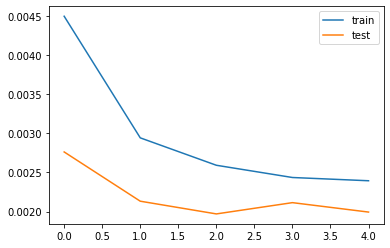

In [7]:
# autoencoder with normalization
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

X_train, X_test, y_train, y_test = X_train1, X_cv1, y_train1, y_cv1
# scale data
n_inputs = X_train.shape[1]
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*0.75)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs*0.65)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs*0.65)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*0.75)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoderwithNorm_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
model.summary()
plot_model(model, 'autoencoderwithNorm.png', show_shapes=True)
history = model.fit(X_train, X_train, epochs=5, batch_size=64, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'autoencoderwithNorm_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('autoencoderwithNorm.h5')

<P>After Applying the ML model I am gonne see which type of Autoencoder I am gonne use or if I am even gonne use the autoencoders or not.</p>

In [6]:
# Random Model
import random
from sklearn.metrics import f1_score

data_train = pd.read_csv('my_final/data.csv')
labels_train = data_train['reordered']

random_label = []
for i in range(len(labels_train)):
    random_label.append(bool(random.getrandbits(1)))

print("F1 score : ", f1_score(labels_train, random_label))
from sklearn.metrics import f1_score
print("F1 score : ", f1_score(labels_train, random_label))

F1 score :  0.16354973285255797
